In [50]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import sklearn
import kaggle
import zipfile
import json

In [51]:
# verifying tensorflow metal installation
print(tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2.16.2
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [52]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [53]:
%kaggle datasets download datasnaek/league-of-legends

UsageError: Line magic function `%kaggle` not found.


In [54]:
zip_ref = zipfile.ZipFile("league-of-legends.zip")
zip_ref.extractall()
zip_ref.close()

In [55]:
%ls

LeaguePickPrediction.ipynb  games.csv
champion_info.json          league-of-legends.zip
champion_info_2.json        summoner_spell_info.json


In [56]:
# opens json file in read mode 
with open('champion_info_2.json', 'r') as f:
    champ_data = json.load(f) # reads the contents of json file and parses it into dict
champ_data = champ_data['data'] # accesses the data key from the champ_data dictionary
champ_list = [] # initialize empty list to hold dictionaries for each champ
for key,value in champ_data.items(): # iterates through each champ
    champ_list.append({ # appends a dictionary of champ info to champlist 
        'champion_id': value['id'], # champs numerical id 
        'champion_key': key, # champs unique string key 
        'champion_name': value['name'], # champ name"
        'tags': ', '.join(value['tags']),# champs tags
        'title':value['title'] # champs title
    })
        
champ_df = pd.DataFrame(champ_list) # converts champ list into a pandas dataframe 
champ_df.head()

,champion_id,champion_key,champion_name,tags,title
0,-1,None,None,,None
1,62,MonkeyKing,Wukong,"Fighter, Tank",the Monkey King
2,24,Jax,Jax,"Fighter, Assassin",Grandmaster at Arms
3,9,Fiddlesticks,Fiddlesticks,"Mage, Support",the Harbinger of Doom
4,35,Shaco,Shaco,Assassin,the Demon Jester


In [57]:
gamesData = pd.read_csv("games.csv")
gamesData.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [58]:
# Convert champion_id to numeric, coercing errors to NaN
champ_df['champion_id'] = pd.to_numeric(champ_df['champion_id'], errors='coerce')

# Convert all champion ID columns in gamesData to numeric
for i in range(1, 6):
    gamesData[f't1_champ{i}id'] = pd.to_numeric(gamesData[f't1_champ{i}id'], errors='coerce')
    gamesData[f't2_champ{i}id'] = pd.to_numeric(gamesData[f't2_champ{i}id'], errors='coerce')

# Now perform the merge
for i in range(1,6):
    # Team 1 merge
    gamesData = gamesData.merge(
        champ_df.rename(columns={
            'champion_name': f't1_champ{i}_name', 
            'tags': f't1_champ{i}_tags'
        }),
        left_on=f't1_champ{i}id', 
        right_on='champion_id', 
        how='left'
    ).drop(columns=['champion_id', 'title', 'champion_key'])
    
    # Team 2 merge
    gamesData = gamesData.merge(
        champ_df.rename(columns={
            'champion_name': f't2_champ{i}_name', 
            'tags': f't2_champ{i}_tags'
        }),
        left_on=f't2_champ{i}id', 
        right_on='champion_id', 
        how='left'
    ).drop(columns=['champion_id', 'title', 'champion_key'])

In [59]:
# Rename columns to remove suffixes like _x and _y
gamesData = gamesData.rename(
    columns=lambda col: col.replace("_y", "").replace("_x", "")
)
gamesData.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_champ3_name,t2_champ3_tags,t1_champ4_name,t1_champ4_tags,t2_champ4_name,t2_champ4_tags,t1_champ5_name,t1_champ5_tags,t2_champ5_name,t2_champ5_tags
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,Darius,"Fighter, Tank",Master Yi,"Assassin, Fighter",Zed,"Assassin, Fighter",Viktor,Mage,Thresh,"Support, Fighter"
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,Hecarim,"Fighter, Tank",Kayle,"Fighter, Support",Yasuo,"Fighter, Assassin",Shaco,Assassin,Riven,"Fighter, Assassin"
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,Jayce,"Fighter, Marksman",Rumble,"Fighter, Mage",Jax,"Fighter, Assassin",Kassadin,"Assassin, Mage",Ashe,"Marksman, Support"
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,Thresh,"Support, Fighter",Orianna,"Mage, Support",Riven,"Fighter, Assassin",Dr. Mundo,"Fighter, Tank",Ashe,"Marksman, Support"
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,Kayn,"Fighter, Assassin",Draven,Marksman,Kassadin,"Assassin, Mage",Syndra,"Mage, Support",Caitlyn,Marksman


In [38]:
# Create a mapping of champion IDs to names
champ_id_to_name = dict(zip(champ_df['champion_id'], champ_df['champion_name']))

# Function to convert champion IDs to names
def get_champ_names(champ_ids, id_to_name_map):
    return [id_to_name_map.get(champ_id, f'Unknown ({champ_id})') for champ_id in champ_ids]

# Function to analyze ban and pick relationships
def analyze_ban_pick_relationship(gamesData, champ_id_to_name):
    # Combine all pick and ban columns
    pick_columns = [
        't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id',
        't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id'
    ]
    ban_columns = [
        't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5',
        't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5'
    ]
    
    # Calculate pick and ban frequencies
    pick_freq = {}
    ban_freq = {}
    
    # Count overall picks
    for col in pick_columns:
        pick_counts = gamesData[col].value_counts()
        for champ, count in pick_counts.items():
            if champ != 0:  # Exclude zero/null values
                pick_freq[champ] = pick_freq.get(champ, 0) + count
    
    # Count overall bans
    for col in ban_columns:
        ban_counts = gamesData[col].value_counts()
        for champ, count in ban_counts.items():
            if champ != 0:  # Exclude zero/null values
                ban_freq[champ] = ban_freq.get(champ, 0) + count
    
    # Convert to names and sort
    pick_freq_named = {
        champ_id_to_name.get(champ_id, f'Unknown ({champ_id})'): count 
        for champ_id, count in sorted(pick_freq.items(), key=lambda x: x[1], reverse=True)
        if champ_id != 0
    }
    
    ban_freq_named = {
        champ_id_to_name.get(champ_id, f'Unknown ({champ_id})'): count 
        for champ_id, count in sorted(ban_freq.items(), key=lambda x: x[1], reverse=True)
        if champ_id != 0
    }
    
    # Detailed analysis with names
    results = {
        'pick_frequencies': pick_freq_named,
        'ban_frequencies': ban_freq_named
    }
    
    return results


In [39]:
# Perform the analysis
ban_pick_analysis = analyze_ban_pick_relationship(gamesData, champ_id_to_name)

# Print top 10 most picked champions
print("Top 10 Most Picked Champions:")
for champ, count in list(ban_pick_analysis['pick_frequencies'].items())[:10]:
    print(f"{champ}: {count} picks")

print("\nTop 10 Most Banned Champions:")
for champ, count in list(ban_pick_analysis['ban_frequencies'].items())[:10]:
    print(f"{champ}: {count} bans")

# Calculate pick rate vs ban rate
total_games = len(gamesData)
print("\nPick and Ban Rates:")
print(f"Total Games: {total_games}")

for champ, pick_count in list(ban_pick_analysis['pick_frequencies'].items())[:10]:
    ban_count = ban_pick_analysis['ban_frequencies'].get(champ, 0)
    pick_rate = (pick_count / total_games) * 100
    ban_rate = (ban_count / total_games) * 100
    
    print(f"{champ}:")
    print(f"  Pick Rate: {pick_rate:.2f}%")
    print(f"  Ban Rate: {ban_rate:.2f}%")

Top 10 Most Picked Champions:
Thresh: 13002 picks
Tristana: 12983 picks
Vayne: 10658 picks
Kayn: 9853 picks
Lee Sin: 9188 picks
Twitch: 8838 picks
Janna: 8691 picks
Lucian: 8300 picks
Jhin: 8044 picks
Jinx: 7980 picks

Top 10 Most Banned Champions:
Yasuo: 33015 bans
Zed: 25393 bans
Cho'Gath: 25175 bans
Darius: 22870 bans
Janna: 21390 bans
Draven: 20262 bans
Blitzcrank: 18795 bans
Kayn: 17384 bans
Twitch: 15832 bans
Zac: 15786 bans

Pick and Ban Rates:
Total Games: 51490
Thresh:
  Pick Rate: 25.25%
  Ban Rate: 11.39%
Tristana:
  Pick Rate: 25.21%
  Ban Rate: 25.38%
Vayne:
  Pick Rate: 20.70%
  Ban Rate: 17.53%
Kayn:
  Pick Rate: 19.14%
  Ban Rate: 33.76%
Lee Sin:
  Pick Rate: 17.84%
  Ban Rate: 12.65%
Twitch:
  Pick Rate: 17.16%
  Ban Rate: 30.75%
Janna:
  Pick Rate: 16.88%
  Ban Rate: 41.54%
Lucian:
  Pick Rate: 16.12%
  Ban Rate: 2.58%
Jhin:
  Pick Rate: 15.62%
  Ban Rate: 3.24%
Jinx:
  Pick Rate: 15.50%
  Ban Rate: 1.71%


In [61]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def numericalPipeline(numericalData):
    """
    Parameter:
    - numericalData, when using this function it only handles numerical dtype
    """
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('std_scaler', StandardScaler())
    ])
    return numerical_pipeline

def categoricalPipeline(textData):
    """
    Parameter:
    - textData: when using this func it only handles categorical dtypes
    """
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('cat_encoder', OneHotEncoder())
    ])
    return cat_pipeline
    
def preprocessor(unprocessedData, num_features, cat_features):
    """
    Parameters:
    - unprocessedData: the raw dataset to preprocess
    - num_featueres: list of columns for numerical features 
    - cat_features: list of columns for categorical features 
    """
    preprocessor = ColumnTransformer([
        ('num', numericalPipeline(unprocessedData[num_features]), num_features),
        ('cat', categoricalPipeline(unprocessedData[cat_features]), cat_features)
    ])
    return preprocessor


In [62]:
features_num = [
        't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5',
        't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5',
        't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id',
        't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id'
    ]
features_cat = [
        't1_champ1_tags', 't1_champ2_tags', 't1_champ3_tags', 't1_champ4_tags', 't1_champ5_tags',
        't2_champ1_tags', 't2_champ2_tags', 't2_champ3_tags', 't2_champ4_tags', 't2_champ5_tags'
    ]
pick_targets = ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']

X = gamesData[features_num + features_cat]
Y = gamesData[pick_targets]
preprocessor_pipeline = preprocessor(gamesData, features_num, features_cat)

X_processed = preprocessor_pipeline.fit_transform(X)
# Check the shapes of X_processed and Y to ensure they match
print(f"Shape of X_processed: {X_processed.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X_processed: (51490, 300)
Shape of Y: (51490, 5)


In [64]:
from sklearn.model_selection import train_test_split
X_temp,X_test,Y_temp,Y_test = train_test_split(X,Y,test_size=.2,random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split(X_temp,Y_temp,test_size=.2,random_state=42)

In [65]:
preprocessor_pipeline = preprocessor(X_train, features_num, features_cat)
X_train_processed = preprocessor_pipeline.fit_transform(X_train)
X_val_processed = preprocessor_pipeline.fit_transform(X_val)
X_test_processed = preprocessor_pipeline.transform(X_test)

In [66]:
# Create the model with the correct input dimension
input_dim = X_train_processed.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train the model
history = model.fit(
    X_train_processed,
    Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_processed, Y_val)
)


/Users/eugene/miniforge3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 19495.1152 - mae: 93.1831 - val_loss: 8064.0630 - val_mae: 64.0787
Epoch 2/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 5391.6250 - mae: 50.3030 - val_loss: 181.0868 - val_mae: 8.8964
Epoch 3/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 59.9593 - mae: 4.8417 - val_loss: 8.7074 - val_mae: 1.8372
Epoch 4/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 2.2057 - mae: 0.8745 - val_loss: 6.1244 - val_mae: 1.5946
Epoch 5/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1221 - mae: 0.1590 - val_loss: 5.9371 - val_mae: 1.5877
Epoch 6/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.0023 - mae: 0.0194 - val_loss: 5.9559 - val_mae: 1.5892
Epoch 7/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 7.3248e-06 - mae: 0.0011 - val_loss: 5.9556 - val_mae: 1.5893
Epoch 8/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 2.3415e-09 - mae: 2.9637e-05 - val_loss: 5.9556 - val_mae: 1.5

In [67]:
test_results = model.evaluate(X_test_processed,Y_test)

322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.1225 - mae: 1.6068


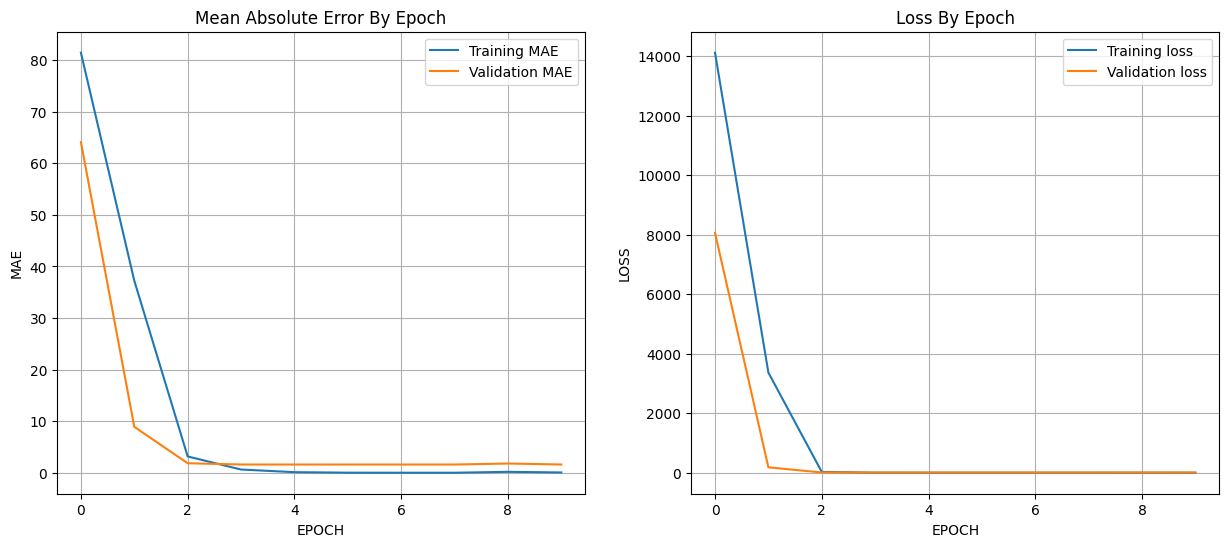

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.history['mae'], label = 'Training MAE')
plt.plot(history.history['val_mae'], label = 'Validation MAE')
plt.title('Mean Absolute Error By Epoch')
plt.xlabel('EPOCH')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss By Epoch')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def predict():
    